<a href="https://colab.research.google.com/github/sandeepalla01/Image-Colorization-using-CNN/blob/main/AML_3104_Image_Colorization_using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importing all the required libraries

In [ ]:
import tensorflow as tf
from keras.callbacks import TensorBoard

In [ ]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, rgb2gray
from skimage.io import imsave
import numpy as np
import os
import random
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from keras import backend as K
from keras.layers import Conv2D,MaxPooling2D,UpSampling2D,Input,BatchNormalization,LeakyReLU
from keras.layers.merge import concatenate
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
# mounting the drive 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# specifying the image path location in drive
ImagePath ="drive/My Drive/Colab_Notebooks/dataset/training_set/painting/"

(224, 224, 3)

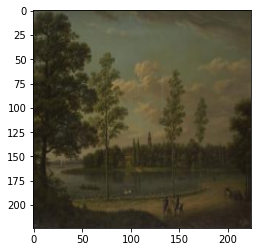

In [ ]:
# Displaying sample image 
img = cv2.imread(ImagePath+"1179.jpg")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (224, 224))
plt.imshow(img)
img.shape

In [ ]:
# converting the colored images into black and white images before feeding to the CNN model
# Here we are divding the image into L (lightness- gray image) and a,b images
HEIGHT=224
WIDTH=224
ImagePath="drive/My Drive/Colab_Notebooks/dataset/training_set/painting/"

def ExtractInput(path):
    X_img=[]
    y_img=[]
    for imageDir in os.listdir(ImagePath):
        try:
            img = cv2.imread(ImagePath + imageDir)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    
            img = img.astype(np.float32)
            img_lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
            # resizing the lightness channel to the network input size as specified earlier
            img_lab_rs = cv2.resize(img_lab, (WIDTH, HEIGHT))
            img_l = img_lab_rs[:,:,0] 
            img_ab = img_lab_rs[:,:,1:]#Extracting the ab channel
            # dividing with 128 makes the ab channel images to fall into the default interval (-128 to 128)
            img_ab = img_ab/128
            X_img.append(img_l)
            y_img.append(img_ab)
        except:
            pass
    # converting the final images into numpy array for better calculation
    X_img = np.array(X_img)
    y_img = np.array(y_img)
    
    return X_img,y_img

In [ ]:
X_,y_ = ExtractInput(ImagePath)

In [ ]:
# applying and instantating the convolution neural network using LeakyReLU 
K.clear_session()
def InstantiateModel(in_):
    model_ = Conv2D(16,(3,3),padding='same',strides=1)(in_)
    model_ = LeakyReLU()(model_)
    #model_ = Conv2D(64,(3,3), activation='relu',strides=1)(model_)
    model_ = Conv2D(32,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    model_ = MaxPooling2D(pool_size=(2,2),padding='same')(model_)
    
    model_ = Conv2D(64,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    model_ = MaxPooling2D(pool_size=(2,2),padding='same')(model_)
    
    model_ = Conv2D(128,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    
    model_ = Conv2D(256,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    
    model_ = UpSampling2D((2, 2))(model_)
    model_ = Conv2D(128,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    
    model_ = UpSampling2D((2, 2))(model_)
    model_ = Conv2D(64,(3,3), padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    #model_ = BatchNormalization()(model_)
    
    concat_ = concatenate([model_, in_]) 
    
    model_ = Conv2D(64,(3,3), padding='same',strides=1)(concat_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    
    model_ = Conv2D(32,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    #model_ = BatchNormalization()(model_)
    
    # output layer with activation function as tanh
    model_ = Conv2D(2,(3,3), activation='tanh',padding='same',strides=1)(model_)

    return model_

In [ ]:
# calling the instantiatemodel
Input_Sample = Input(shape=(HEIGHT, WIDTH,1))
Output_ = InstantiateModel(Input_Sample)
Model_Colourization = Model(inputs=Input_Sample, outputs=Output_)

In [ ]:
# compiling the model using optimizer as Adam
LEARNING_RATE = 0.001
Model_Colourization.compile(optimizer=Adam(lr=LEARNING_RATE),
                            loss='mean_squared_error',metrics=['accuracy'])
# summary of the model
Model_Colourization.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 224, 224, 16  0           ['conv2d[0][0]']                 
                                )                                                             

In [ ]:
def GenerateInputs(X_,y_):
    for i in range(len(X_)):
        X_input = X_[i].reshape(1,224,224,1)
        y_input = y_[i].reshape(1,224,224,2)
        yield (X_input,y_input)
# fitting the model with epochs as 53
Model_Colourization.fit(GenerateInputs(X_,y_),epochs=75,verbose=1,steps_per_epoch=10,shuffle=True)

Epoch 1/75
10/10 [==============================] - 1s 30ms/step - loss: 0.0194 - accuracy: 0.7749
Epoch 2/75
10/10 [==============================] - 0s 24ms/step - loss: 0.0061 - accuracy: 0.0857
Epoch 3/75
10/10 [==============================] - 0s 23ms/step - loss: 0.0034 - accuracy: 0.5915
Epoch 4/75
10/10 [==============================] - 0s 23ms/step - loss: 0.0024 - accuracy: 0.9024
Epoch 5/75
10/10 [==============================] - 0s 23ms/step - loss: 0.0017 - accuracy: 0.4045
Epoch 6/75
10/10 [==============================] - 0s 23ms/step - loss: 0.0014 - accuracy: 0.7694
Epoch 7/75
10/10 [==============================] - 0s 23ms/step - loss: 5.5133e-04 - accuracy: 0.1895
Epoch 8/75
10/10 [==============================] - 0s 23ms/step - loss: 3.9922e-04 - accuracy: 0.6723
Epoch 9/75
10/10 [==============================] - 0s 22ms/step - loss: 2.6692e-04 - accuracy: 0.5127
Epoch 10/75
10/10 [==============================] - 0s 23ms/step - loss: 1.1604e-04 - accuracy: 

In [ ]:
TestImagePath="drive/My Drive/Colab_Notebooks/dataset/training_set/iconography/"

In [ ]:
#Extracting the test image input
def ExtractTestInput(ImagePath):
    img = cv2.imread(ImagePath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img_ = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    img_ = cv2.cvtColor(img_, cv2.COLOR_RGB2Lab)
    img_=img_.astype(np.float32)
    img_lab_rs = cv2.resize(img_, (WIDTH, HEIGHT)) # resize image to network input size
    img_l = img_lab_rs[:,:,0] # pull out L channel
    img_l_reshaped = img_l.reshape(1,224,224,1)
    
    return img_l_reshaped

### Testing images in Iconography category

In [ ]:
ImagePath=TestImagePath+"sandeep.jpeg"
image_for_test = ExtractTestInput(ImagePath)
Prediction = Model_Colourization.predict(image_for_test)
Prediction = Prediction*128
Prediction=Prediction.reshape(224,224,2)

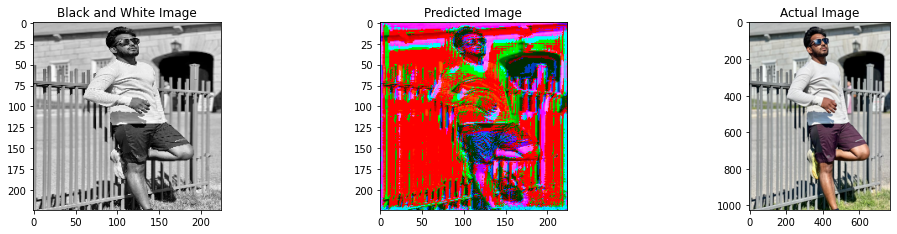

In [ ]:
plt.figure(figsize=(30,20))
plt.subplot(5,5,1)
img = cv2.imread(TestImagePath+"sandeep.jpeg")
img_1 = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img_1, cv2.COLOR_RGB2GRAY)
img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
img = cv2.resize(img, (224, 224))
plt.title("Black and White Image")
plt.imshow(img)

plt.subplot(5,5,1+1)
img_ = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
img_[:,:,1:] = Prediction
img_ = cv2.cvtColor(img_, cv2.COLOR_Lab2RGB)
plt.title("Predicted Image")
plt.imshow(img_)

plt.subplot(5,5,1+2)
plt.title("Actual Image")
plt.imshow(img_1)

In [ ]:
ImagePath=TestImagePath+"315.jpg"
image_for_test = ExtractTestInput(ImagePath)
Prediction_1 = Model_Colourization.predict(image_for_test)
Prediction_1 = Prediction_1*128
Prediction_1=Prediction_1.reshape(224,224,2)

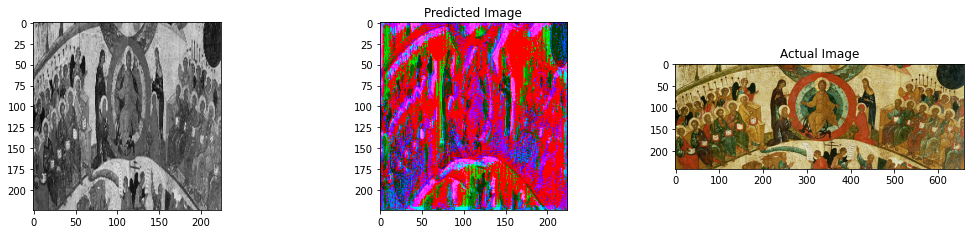

In [ ]:
plt.figure(figsize=(30,20))
plt.subplot(5,5,1)
img = cv2.imread(TestImagePath+"315.jpg")
img_1 = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img_1, cv2.COLOR_RGB2GRAY)
img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
img = cv2.resize(img, (224, 224))
plt.imshow(img)

plt.subplot(5,5,1+1)
img_ = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
img_[:,:,1:] = Prediction_1
img_ = cv2.cvtColor(img_, cv2.COLOR_Lab2RGB)
plt.title("Predicted Image")
plt.imshow(img_)

plt.subplot(5,5,1+2)
plt.title("Actual Image")
plt.imshow(img_1)

In [ ]:
ImagePath=TestImagePath+"225.jpg"
image_for_test = ExtractTestInput(ImagePath)
Prediction_2 = Model_Colourization.predict(image_for_test)
Prediction_2 = Prediction_2*128
Prediction_2=Prediction_2.reshape(224,224,2)

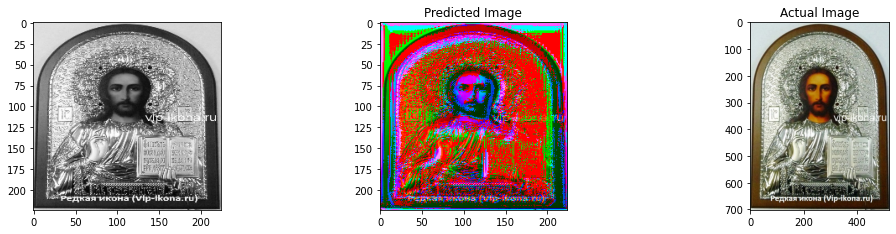

In [ ]:
plt.figure(figsize=(30,20))
plt.subplot(5,5,1)
img = cv2.imread(TestImagePath+"225.jpg")
img_1 = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img_1, cv2.COLOR_RGB2GRAY)
img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
img = cv2.resize(img, (224, 224))
plt.imshow(img)

plt.subplot(5,5,1+1)
img_ = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
img_[:,:,1:] = Prediction_2
img_ = cv2.cvtColor(img_, cv2.COLOR_Lab2RGB)
plt.title("Predicted Image")
plt.imshow(img_)

plt.subplot(5,5,1+2)
plt.title("Actual Image")
plt.imshow(img_1)

## Testing the images in Sculpture category

In [ ]:
TestImagePath="drive/My Drive/Colab_Notebooks/dataset/training_set/sculpture/91.jpg"
image_for_test = ExtractTestInput(TestImagePath)
Prediction_3 = Model_Colourization.predict(image_for_test)
Prediction_3 = Prediction_3*128
Prediction_3=Prediction_3.reshape(224,224,2)

In [ ]:
plt.figure(figsize=(30,20))
plt.subplot(5,5,1)
img = cv2.imread(TestImagePath)
img_1 = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img_1, cv2.COLOR_RGB2GRAY)
img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
img = cv2.resize(img, (224, 224))
plt.imshow(img)

plt.subplot(5,5,1+1)
img_ = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
img_[:,:,1:] = Prediction_3
img_ = cv2.cvtColor(img_, cv2.COLOR_Lab2RGB)
plt.title("Predicted Image")
plt.imshow(img_)

plt.subplot(5,5,1+2)
plt.title("Actual Image")
plt.imshow(img_1)

## Testing the images in Painting Categroy

In [ ]:
TestImagePath="drive/My Drive/Colab_Notebooks/dataset/training_set/painting/1602.jpg"
image_for_test = ExtractTestInput(TestImagePath)
Prediction_4 = Model_Colourization.predict(image_for_test)
Prediction_4 = Prediction_4*128
Prediction_4=Prediction_4.reshape(224,224,2)

In [ ]:
plt.figure(figsize=(30,20))
plt.subplot(5,5,1)
img = cv2.imread(TestImagePath)
img_1 = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img_1, cv2.COLOR_RGB2GRAY)
img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
img = cv2.resize(img, (224, 224))
plt.imshow(img)

plt.subplot(5,5,1+1)
img_ = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
img_[:,:,1:] = Prediction_4
img_ = cv2.cvtColor(img_, cv2.COLOR_Lab2RGB)
plt.title("Predicted Image")
plt.imshow(img_)

plt.subplot(5,5,1+2)
plt.title("Actual Image")
plt.imshow(img_1)

In [ ]:
TestImagePath="drive/My Drive/Colab_Notebooks/dataset/training_set/painting/1578.jpg"
image_for_test = ExtractTestInput(TestImagePath)
Prediction_5 = Model_Colourization.predict(image_for_test)
Prediction_5 = Prediction_5*128
Prediction_5=Prediction_5.reshape(224,224,2)

In [ ]:
plt.figure(figsize=(30,20))
plt.subplot(5,5,1)
img = cv2.imread(TestImagePath)
img_1 = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img_1, cv2.COLOR_RGB2GRAY)
img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
img = cv2.resize(img, (224, 224))
plt.imshow(img)

plt.subplot(5,5,1+1)
img_ = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
img_[:,:,1:] = Prediction_5
img_ = cv2.cvtColor(img_, cv2.COLOR_Lab2RGB)
plt.title("Predicted Image")
plt.imshow(img_)

plt.subplot(5,5,1+2)
plt.title("Actual Image")
plt.imshow(img_1)

## Conclusion

##### The Model can identify the correct pattern or shades in which the color must be filled or can say the model is able to separate out the portions which is needed to be colored to get the colorized image but is not able to predict the accurate color for that shade or portion all the time with respect to the ground truth image.

##### This issue can be overcome with the help of feature extraction with ResNet.

##### The results also reflects that there is a scope for applying he GAN and other image colorization techniques